In [21]:
# %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [22]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [24]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [25]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [26]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [27]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [28]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [29]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first()
most_recent_date

('2017-08-23',)

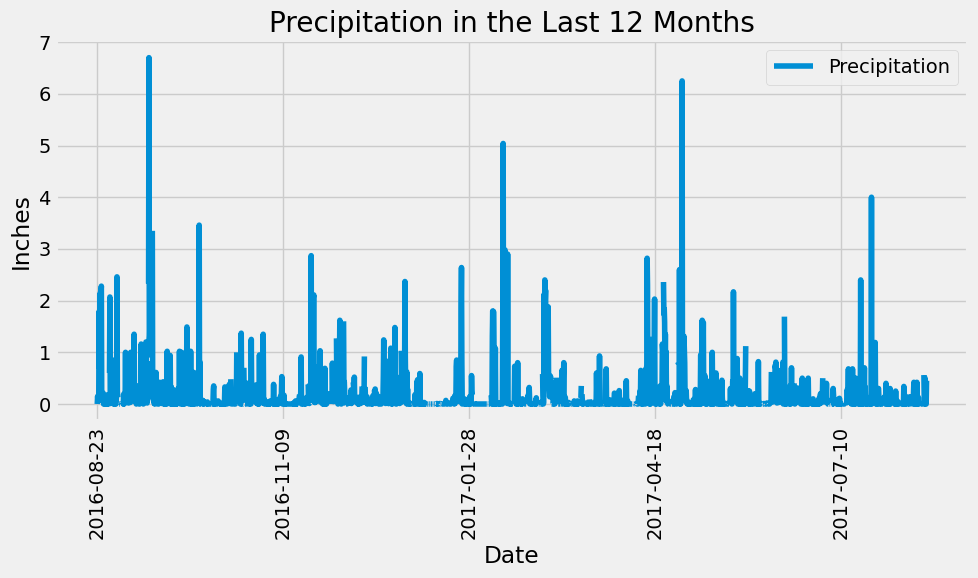

In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago)\
    .order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=["Date", "Precipitation"])


# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by="Date")

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.set_index("Date").plot(rot=90, figsize=(10, 6))
plt.ylabel("Inches")
plt.title("Precipitation in the Last 12 Months")
plt.tight_layout()
plt.show()


In [31]:
# Query to retrieve the date and precipitation data
query_results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23').all()

In [33]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_data = pd.DataFrame(query_results, columns=['date', 'precipitation'])

# Calculate summary statistics
precipitation_summary = pd.DataFrame(precipitation_data['precipitation'].describe())
precipitation_summary.rename(columns={'precipitation': 'Precipitation'}, inplace=True)
precipitation_summary


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [34]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()
total_stations

[(9,)]

In [35]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [36]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active_stations[0][0]
temperature_stats = (session.query(func.min(Measurement.tobs),
                                   func.max(Measurement.tobs),
                                   func.avg(Measurement.tobs))
                     .filter(Measurement.station == most_active_station)
                     .all())
temperature_stats

[(54.0, 85.0, 71.66378066378067)]

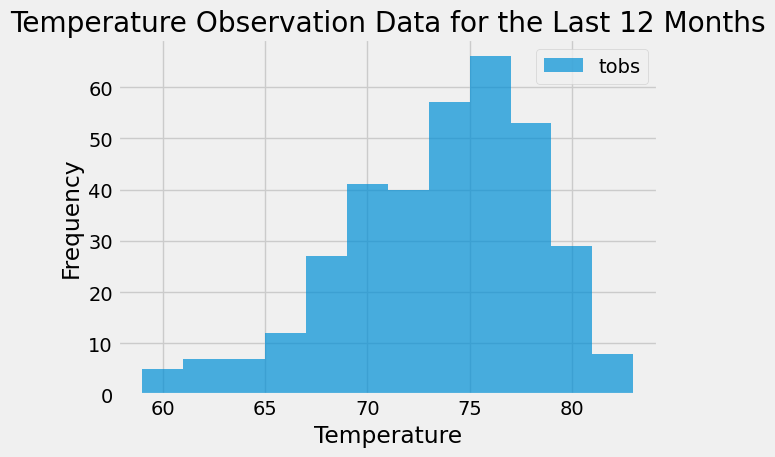

In [37]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12_months_tobs = (session.query(Measurement.tobs)
                       .filter(Measurement.station == most_active_station)
                       .filter(Measurement.date >= one_year_ago)
                       .all())
# Convert the query results to a list
tobs_list = [temp[0] for temp in last_12_months_tobs]

# Create the histogram
plt.hist(tobs_list, bins=12, label="tobs", alpha=0.7)

# Add labels and title
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature Observation Data for the Last 12 Months")
plt.legend(loc='best')

# Show the plot
plt.tight_layout()
plt.show()

# Close Session

In [38]:
# Close Session
session.close()